# Prévision débordements d'égouts

# Introduction 
<hr>
Le système d'égoût de Montréal a pour responsabilité de gérer adéquatement les eaux usées domestiques, comme les eaux de cuisines ou celles produites par l'usage des salles de bains et de certains appareils ménagés, ainsi que les rejets industriels en les acheminant aux stations d'épurations de la ville pour qu'elles puissent être traitées. Les eaux de pluie s'ajoutent aux eaux conduites par ce réseau et il arrive alors, en temps de fortes pluies par exemple, qu'il soit surchargé et incapable d'amener la totalité du flot vers les stations d'épuration. Une portion des eaux usées est alors déversée directement dans les cours d'eau avoisinants, compromettant leur préservation et la santé publique.


Ainsi, ce projet vise à prédire, pour l'année 2019, l'occurence de surverses du système d'égoûts de Montréal en fonction de données pluviométriques. Précisément, on cherche à prévoir si, pour des journées et des ouvrages de surverse spécifiques, il y aura un débordement de l'ouvrage en question en considérant des mesures sur la quantité de pluie tombée enregistrées par 5 stations météorologiques.

Ce calepin présente la démarche mise en oeuvre pour atteindre cet objectif. La préparation des données détenues est d'abord montrée, la gestion des valeurs manquantes dans les jeux de données est ensuite traitée puis les différents modèles de prédiction conçus et les résultats obtenus seront détaillés.

Avant tout, on importe les librairies qui seront utiles dans l'atteinte de notre but.

# Somaire
<hr>

1. **[Chargement des données et nettoyage préliminaire](#1)** <br>
    1.1 - Chargement des surverses <br>
    1.2 - Nettoyage des données sur les surverses <br>
    1.3 - Chargement des précipitations <br>
    1.4 - Nettoyage des données sur les précipitations <br>
    1.5 - Nettoyage des missing sur les précipitations <br>
    1.6 - Traitement des anomalies de précipitations pour les stations <br>
2. **[Analyse exploratoire](#2)**
3. **[Modèle de régression logistique](#3)** <br>
    3.1 - Introduction <br>
    3.2 - Créations des données nécessaires <br>
    3.3 - Encodage des variables précipitations à l'aide de de cinq variables indicatrices <br>
    3.4 - Estimation des paramètres du modèle de régression logistique <br>
    3.5 - Prédiction des surverses pour l'ensemble de test <br>
    3.5.1 - Chargement des données de l'ensemble de test</i> <br>
    3.5.2 - Encoder les variables précipitations des stations de l'ensemble de test avec cinq variables indicatrices <br>
    3.5.3 - Estimation de la probabilité de surverses de chacune des stations de l'ensemble de test <br>
    3.5.4 - Prédiction des surverses des ouvrages de l'ensemble de test <br>
    3.6 - Conclusion <br>
4. **[Arbre de Décision](#4)** <br>
    4.1 - Filtrage de données dans des dataframes <br>
    4.2 - Arbre de forêt aléatoire <br>
    4.2.1 -Introduction<br>
    4.2.2 -Création des forêts<br>
    4.2.3 -Analyse des forêts crées <br>
    4.2.4 - Création d'une fonction pour faire appel aux modèles forêt aléatoire <br>
    4.2.5 - Conclusion <br>
    4.3 - Forêt aléatoire avec Adaboost<br>
    4.3.1 - Résumé<br>
    4.3.2 - Application du modèle<br>
    4.3.3 - Création de la forêt aleatoire Adaboost<br>
    4.3.4 - Analyse des forêts adaboost crées <br>
    4.3.5 - Création d'une fonction pour faire appel aux modèles forêt adaboost<br>
    4.3.6 - Conclusion<br>
5. **[Methode Bayesienne Naive](#5)** <br>

In [1]:
using CSV, DataFrames, Statistics, Dates, Gadfly, DecisionTree, ScikitLearn, PyCall

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/imranebelhadia/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


ArgumentError: ArgumentError: Package DecisionTree not found in current path:
- Run `import Pkg; Pkg.add("DecisionTree")` to install the DecisionTree package.


In [2]:
using Random, StatsBase,Distributions

In [3]:
using GLM, Distributions, LinearAlgebra

In [4]:
@pyimport IPython.display as d

LoadError: UndefVarError: @pyimport not defined

<a id="1"></a>
# 1 - Chargement des données et nettoyage préliminaire

## 1.1 - Chargement des surverses

In [5]:
data = CSV.read("data/surverses.csv", missingstring="-99999")
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,0642-01D,2013-05-01,0,missing
2,0642-01D,2013-05-02,0,missing
3,0642-01D,2013-05-03,0,missing
4,0642-01D,2013-05-04,0,missing
5,0642-01D,2013-05-05,0,missing


## 1.2 - Nettoyage des données sur les surverses

#### Extraction des surverses pour les mois de mai à octobre inclusivement

In [6]:
data = filter(row -> month(row.DATE) > 4, data) 
data = filter(row -> month(row.DATE) < 11, data) 
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,0642-01D,2013-05-01,0,missing
2,0642-01D,2013-05-02,0,missing
3,0642-01D,2013-05-03,0,missing
4,0642-01D,2013-05-04,0,missing
5,0642-01D,2013-05-05,0,missing


#### Remplacement des valeurs *missing* dans la colonne :RAISON par "Inconnue"

In [7]:
raison = coalesce.(data[:,:RAISON],"Inconnue")
data[!,:RAISON] = raison
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String
1,0642-01D,2013-05-01,0,Inconnue
2,0642-01D,2013-05-02,0,Inconnue
3,0642-01D,2013-05-03,0,Inconnue
4,0642-01D,2013-05-04,0,Inconnue
5,0642-01D,2013-05-05,0,Inconnue


#### Exlusion des surverses coccasionnées par d'autres facteurs que les précipitations liquides

Ces facteurs correspondent à : 
- la fonte de neige (F), 
- les travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

In [8]:
data = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], data) 
select!(data, [:NO_OUVRAGE, :DATE, :SURVERSE])
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE
,String,Date,Int64⍰
1,0642-01D,2013-05-01,0
2,0642-01D,2013-05-02,0
3,0642-01D,2013-05-03,0
4,0642-01D,2013-05-04,0
5,0642-01D,2013-05-05,0


#### Exclusion des lignes où :SURVERSE est manquante

In [9]:
surverse_df = dropmissing(data, disallowmissing=true)
first(surverse_df,5)

,NO_OUVRAGE,DATE,SURVERSE
,String,Date,Int64
1,0642-01D,2013-05-01,0
2,0642-01D,2013-05-02,0
3,0642-01D,2013-05-03,0
4,0642-01D,2013-05-04,0
5,0642-01D,2013-05-05,0


## 1.3 - Chargement des précipitations

In [10]:
data₂ = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(data₂, Symbol("St-Hubert")=>:StHubert)
first(data₂,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-01-01,0,0,0,0,0,missing
2,2013-01-01,1,0,0,0,0,missing
3,2013-01-01,2,0,0,0,0,missing
4,2013-01-01,3,0,0,0,0,missing
5,2013-01-01,4,0,0,0,0,missing


## 1.4 - Nettoyage des données sur les précipitations

#### Extraction des précipitations des mois de mai à octobre inclusivement

In [11]:
data₂ = filter(row -> month(row.date) > 4, data₂) 
data₂ = filter(row -> month(row.date) < 11, data₂) 
first(data₂,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-05-01,0,0,0,0,0,missing
2,2013-05-01,1,0,0,0,0,missing
3,2013-05-01,2,0,0,0,0,missing
4,2013-05-01,3,0,0,0,0,missing
5,2013-05-01,4,0,0,0,0,missing


## 1.5 - Nettoyage des missing sur les précipitations

### Matrice des distances d'une station (ligne i) a une autre (rangé j)

In [12]:
distance = [[0, 2, 3, 1, 1] [2, 0, 5, 1, 3] [3, 5, 0, 4, 3] [1, 1, 4, 0, 2] [1, 3, 3, 2, 0] ]
#distance = 1 ./ distance

5×5 Array{Int64,2}:
 0  2  3  1  1
 2  0  5  1  3
 3  5  0  4  3
 1  1  4  0  2
 1  3  3  2  0

In [13]:
#               [0,       0.03479, 0.02802, 0.07508, 0.07862;
#                0.03479, 0,       0.01753, 0.06481, 0.02419;
#                0.02802, 0.01753, 0,       0.02229, 0.03078;
#                0.07508, 0.06481, 0.02229, 0,       0.03860;
#                0.07862, 0.02419, 0.03078, 0.03860, 0      ]

### Remplacement des missing par la moyenne pondérer des autres stations en fonction des distances

In [14]:
function getNewVal(i, x)
    newValue = 0
    totalDistance = 1

    if !ismissing(data₂.McTavish[i])
        newValue = newValue + data₂.McTavish[i] * distance[x, 1] 
        totalDistance = totalDistance + distance[x, 1]
    end
    if !ismissing(data₂.Bellevue[i])
        newValue = newValue + data₂.Bellevue[i] * distance[x, 2] 
        totalDistance = totalDistance + distance[x, 2]
    end
    if !ismissing(data₂.Assomption[i])
        newValue = newValue + data₂.Assomption[i] * distance[x, 3]
        totalDistance = totalDistance + distance[x, 3]
    end
    if !ismissing(data₂.Trudeau[i])
        newValue = newValue + data₂.Trudeau[i] * distance[x, 4]
        totalDistance = totalDistance + distance[x, 4]
    end
    if !ismissing(data₂.StHubert[i])
        newValue = newValue + data₂.StHubert[i] * distance[x, 5]
        totalDistance = totalDistance + distance[x, 5]
    end

    if totalDistance > 1
        totalDistance = totalDistance - 1
    end
        
    return floor(newValue / totalDistance)
end

getNewVal (generic function with 1 method)

In [15]:
function replaceMissing()
    
    n = size(data₂, 1)
    
    for i=1:n
        
        if ismissing(data₂.McTavish[i])
            data₂.McTavish[i] = getNewVal(i, 1)
        end
        if ismissing(data₂.Bellevue[i])
            data₂.Bellevue[i] = getNewVal(i, 2)
        end
        if ismissing(data₂.Assomption[i])
            data₂.Assomption[i] = getNewVal(i, 3)
        end
        if ismissing(data₂.Trudeau[i])
            data₂.Trudeau[i] = getNewVal(i, 4)
        end
        if ismissing(data₂.StHubert[i])
            data₂.StHubert[i] = getNewVal(i, 5)
        end
    end    
end

replaceMissing (generic function with 1 method)

In [16]:
replaceMissing()

## 1.6 - Traitement des anomalies de précipitations pour les stations

In [17]:
outofbound₁ = filter(row -> row.McTavish > 1000, data₂)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-10-10,13,2082,0,0,0,231


In [18]:
outofbound₂ = filter(row -> row.Bellevue > 1000, data₂)
outofbound₃ = filter(row -> row.Assomption > 1000, data₂)
outofbound₄ = filter(row -> row.Trudeau > 1000, data₂)
outofbound₅ = filter(row -> row.StHubert > 1000, data₂)

[size(outofbound₂, 1) size(outofbound₃, 1) size(outofbound₄, 1) size(outofbound₅, 1)]

1×4 Array{Int64,2}:
 0  0  0  0

In [19]:
m = findall(x -> x > 1000, data₂.McTavish)

1-element Array{Int64,1}:
 3902

In [20]:
for i=1:size(m, 1)
    data₂.McTavish[m[i]] = getNewVal(m[i], 1)
end

In [21]:
filter(row -> row.McTavish > 1000, data₂)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰


<a id="2"></a>
# 2 - Analyse exploratoire

Cette section consitue une analyse exploratoire superficielle permettant de voir s'il existe un lien entre les précipitations et les surverses.

Prenons arbitrairement l'ouvrage de débordement près du Bota-Bota (4350-01D). La station météorologique la plus proche est McTavish. Prenons deux variables explicatives simple :
- la somme journalière des précipitations
- le taux horaire maximum journalier de précipitations

#### Calcul de la quantité journalière de précipitations pour chacune des stations météorologiques

In [22]:
pcp_sum = by(data₂, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
   Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum)
first(pcp_sum ,5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2013-05-01,0,0,0,0,0
2,2013-05-02,0,0,0,0,0
3,2013-05-03,0,0,0,0,0
4,2013-05-04,0,0,0,0,0
5,2013-05-05,0,0,0,0,0


#### Extraction du taux horaire journalier maximum des précipitations pour chacune des stations météorologiques

In [23]:
pcp_max = by(data₂, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)
first(pcp_max,5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2013-05-01,0,0,0,0,0
2,2013-05-02,0,0,0,0,0
3,2013-05-03,0,0,0,0,0
4,2013-05-04,0,0,0,0,0
5,2013-05-05,0,0,0,0,0


#### Inclusion dans un dataframe de ces deux variables explicatives potentielles

In [24]:
ouvrage = "4350-01D"

df = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)

x₁ = Array{Union{Missing, Int64}}(missing, size(df,1)) # variable pour la somme journalière
x₂ = Array{Union{Missing, Int64}}(missing, size(df,1)) # variable pour le max journalier


for i=1:size(df,1)
    
    ind = findfirst(pcp_sum[:,:date] .== df[i,:DATE])
    
    x₁[i] = pcp_sum[ind,:McTavish]
    
    ind = findfirst(pcp_max[:,:date] .== df[i,:DATE])
    
    x₂[i] = pcp_max[ind,:McTavish]
    
end

df[!,:SUM] = x₁
df[!,:MAX] = x₂

first(df, 5)

,NO_OUVRAGE,DATE,SURVERSE,SUM,MAX
,String,Date,Int64,Int64⍰,Int64⍰
1,4350-01D,2013-05-01,0,0,0
2,4350-01D,2013-05-02,0,0,0
3,4350-01D,2013-05-03,0,0,0
4,4350-01D,2013-05-04,0,0,0
5,4350-01D,2013-05-05,0,0,0


#### Traçage des distribution de la somme des précipitations en fonction des surverses ou non

On remarque que les deux distributions sont très différentes. Ceci suggère que la somme des précipitations à la station McTavish a un effet sur les surverses au Bota-Bota.

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping(::DataFrame, ::Symbol) at dataframes.jl:96
└ @ Gadfly /Users/imranebelhadia/.julia/packages/Gadfly/09PWZ/src/dataframes.jl:96


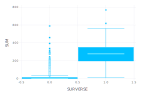

In [25]:
plot(df, x=:SURVERSE, y=:SUM, Geom.boxplot)

#### Traçage des distribution de la somme des précipitations en fonction des surverses ou non

On remarque que les deux distributions sont très différentes. Ceci suggère que le maximum journalier des précipitations à la station McTavish a un effet sur les surverses au Bota-Bota.

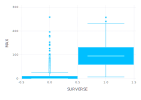

In [26]:
plot(df, x=:SURVERSE, y=:MAX, Geom.boxplot)

On peu conclure que les deux variables explicative ci-haut on de bonnes chances d'etre utile pour la classification. Il peut etre utile d'en ajouter davantage. Une variable qui semblre simplre a explorer et celle du mois, puisque la date est l'une de nos entrée, peut etre que certains mois il est plus probable d'observer une surverse qu'a d'autres.

### Distribution des mois pour les jours où il y a eu une surverse

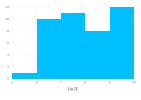

In [27]:
df_month = copy(df)
df_month[!,:DATE] = month.(df_month[!,:DATE])
plot(filter!( row -> row.SURVERSE == 1,df_month), x =:DATE, Geom.histogram)

### Distribution des mois pour les jours où il y n'y a pas eu de surverse

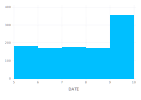

In [28]:
df_month = copy(df)
df_month[!,:DATE] = month.(df_month[!,:DATE])
plot(filter!(row -> row.SURVERSE == 0,df_month), x =:DATE, Geom.histogram)

On observe qu'il n'ya pas de difference importante dans la repartition des mois pour les deux classe que nous voulons distiguer. Il est possible de rejeter les mois dès maintenant. Nous avons tout de meme poursuivi en essayant de les inclures dans certain de nos modèles, mais comme attendu, cette variable explicative n'as eu aucun effet (ni positif, ni negatif). Les manipulation concernant les mois n'ont pas été inclues dans ce document.

<a id="3"></a>
# 3 - Modèle de régression logistique 

La somme des précipitations en une journée est utilisée comme variable explicative de la probabilité d'une surverse.

## 3.1 - Introduction

Comme vue en cours, la régression logistique, qui est un type de modèle linéaire généralisé pour les variables aléatoires (type Bernoulli), est utilisée pour classer les observations en deux catégories.
Nous utiliserons donc cette méthode dans la section suivante pour essayer de classer les observations sur les surverses et précipitations grâce a des variables explicatives.

## 3.2 - Créations des données nécessaires

In [29]:
rename!(pcp_sum, :date=>:DATE)
first(pcp_sum, 1)

,DATE,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2013-05-01,0,0,0,0,0


Nous allons créer un deuxième dataframe afin d'avoir accès aux informations sur les précipitations tout en ayant l'information s'il y a eu surverse ou non pour ces précipiations. 

In [30]:
pcp_sum_2 = join(surverse_df, pcp_sum, on = :DATE, makeunique=true)
first(pcp_sum_2, 1)

,NO_OUVRAGE,DATE,SURVERSE,McTavish,Bellevue,Assomption,Trudeau,StHubert
,String,Date,Int64,Int64,Int64,Int64,Int64,Int64
1,0642-01D,2013-05-01,0,0,0,0,0,0


## 3.3 - Encodage des variables précipitations à l'aide de de cinq variables indicatrices

Pour cette section ci, nous utiliserons les variables indicatices / explicatives suivantes : <br>
x1 = { 1 si la somme des précipitations de la station McTavish dépasse 400, 0 sinon } <br>
x2 = { 1 si la somme des précipitations de la station Bellevue dépasse 400, 0 sinon } <br>
x3 = { 1 si la somme des précipitations de la station Assomption dépasse 400, 0 sinon } <br>
x4 = { 1 si la somme des précipitations de la station Trudeau dépasse 400, 0 sinon } <br>
x5 = { 1 si la somme des précipitations de la station StHubert dépasse 400, 0 sinon } <br>
<br>
Nous avons essayé de prendre les mois comme variables explicatives, mais sans grand succès. De même pour la somme des précipitations comme variables explicatives, nous avons essayé plusieurs valeures et 400 semble être la plus prométteuse.

In [31]:
n = size(pcp_sum_2, 1)

x₁ = zeros(n)
x₂ = zeros(n)
x₃ = zeros(n)
x₄ = zeros(n)
x₅ = zeros(n)

for i=1:n
    if pcp_sum_2.McTavish[i] >= 400
        x₁[i] = 1
    end
    
    if pcp_sum_2.Bellevue[i] >= 400
        x₂[i] = 1
    end
    
    if pcp_sum_2.Assomption[i] >= 400
        x₃[i] = 1
    end
    
    if pcp_sum_2.Trudeau[i] >= 400
        x₄[i] = 1
    end
    
    if pcp_sum_2.StHubert[i] >= 400
        x₅[i] = 1
    end    
end

[x₁ x₂ x₃ x₄ x₅]

161098×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 ⋮                      
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

## 3.4 - Estimation des paramètres du modèle de régression logistique

In [32]:
df₂ = DataFrame(x₁=x₁,x₂=x₂,x₃=x₃,x₄=x₄,x₅=x₅,Y=pcp_sum_2[:,:SURVERSE])

M = glm(@formula(Y ~ x₁+x₂+x₃+x₄+x₅), df₂,  Bernoulli(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Bernoulli{Float64},LogitLink},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + x₁ + x₂ + x₃ + x₄ + x₅

Coefficients:
──────────────────────────────────────────────────────────────────────────────
              Estimate  Std. Error     z value  Pr(>|z|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  -3.44131    0.0144241  -238.58       <1e-99  -3.46958   -3.41304 
x₁            1.91738    0.127077     15.0883     <1e-50   1.66831    2.16645 
x₂            1.85335    0.148907     12.4464     <1e-34   1.5615     2.14521 
x₃            2.28835    0.0704656    32.4747     <1e-99   2.15024    2.42646 
x₄           -1.85349    0.172399    -10.7511     <1e-26  -2.19138   -1.51559 
x₅           -0.643678   0.141186     -4.55909    <1e-5   -0.920397  -0.366959
──────────────────────────────────────────────

## 3.5 - Prédiction des surverses pour l'ensemble de test

### 3.5.1 - Chargement des données de l'ensemble de test

In [33]:
test = CSV.read("data/test.csv")

first(test, 5)

,NO_OUVRAGE,DATE
,String,Date
1,3260-01D,2019-05-02
2,3260-01D,2019-05-09
3,3260-01D,2019-05-10
4,3260-01D,2019-05-15
5,3260-01D,2019-05-20


Par analogie avec la section 3.1, nous avons besoin de regrouper les inforations quand aux date et pricipations par stations associées à ces dates.

In [34]:
pcp_sum_test = join(pcp_sum, test, on = :DATE, makeunique=true)

first(pcp_sum_test, 5)

,DATE,McTavish,Bellevue,Assomption,Trudeau,StHubert,NO_OUVRAGE
,Date,Int64,Int64,Int64,Int64,Int64,String
1,2019-05-01,79,52,58,47,68,3350-07D
2,2019-05-02,26,19,15,13,17,3260-01D
3,2019-05-02,26,19,15,13,17,3350-07D
4,2019-05-02,26,19,15,13,17,4380-01D
5,2019-05-03,34,27,34,31,44,4350-01D


### 3.5.2 - Encoder les variables précipitations des stations de l'ensemble de test avec cinq variables indicatrices

In [35]:
n = size(pcp_sum_test, 1)

x̃₁ = zeros(n)
x̃₂ = zeros(n)
x̃₃ = zeros(n)
x̃₄ = zeros(n)
x̃₅ = zeros(n)

for i=1:n
    if pcp_sum_test.McTavish[i] >= 400
        x̃₁[i] = 1
    end
    
    if pcp_sum_test.Bellevue[i] >= 400
        x̃₂[i] = 1
    end
    
    if pcp_sum_test.Assomption[i] >= 400
        x̃₃[i] = 1
    end
    
    if pcp_sum_test.Trudeau[i] >= 400
        x̃₄[i] = 1
    end
    
    if pcp_sum_test.StHubert[i] >= 400
        x̃₅[i] = 1
    end    
end

X̃ = hcat(ones(Int64,n),x̃₁,x̃₂,x̃₃,x̃₄,x̃₅)

283×6 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮  
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0

### 3.5.3 - Estimation de la probabilité de surverses de chacune des stations de l'ensemble de test

In [36]:
θ̂ = predict(M, X̃)

283-element Array{Float64,1}:
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 ⋮                   
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003
 0.031029088040439003

### 3.5.4 - Prédiction des surverses des ouvrages de l'ensemble de test

In [37]:
Ŷ = zeros(Int64,n)

Ŷ[θ̂.>.5] .= 1;

## 3.6 - Conclusion

Comme nous pouvons le voir, notre modèle de régression logistique ne produit peu/pas de bonnes prédictions. On peut voir que les valeurs de l'estimateur de surverses pour l'ensemble de test ne dépasse pas en moyenne <b>0.031029</b> ce qui est loin de <b>0.5</b>. Le fichier sampleSubmission.csv ne contenant que des 0 n'à pas était retenue. Quand au manque de précision du modèle, voici nos deux hypothèses : <br>
1 - Les variables explicatives : <br>
Soit celles utilisées pour le modèles ne sont pas appropriés ou alors il en manque. Cependant nous avons essayer de combiner les mois et la sommes des précipitations sans changement des valeurs de facon significative. <br>
2 - Le modèle : <br>
Le modèle utilisé peu ne pas être adapté pour les données que nous utilisons. <br>
<br>
<u>Suit à cela, nous avons donc essayer d'utiliser les forets d'arbres aléatoires.</u>

<a id="4"></a>
# 4 - Arbres de décisions

Dans cette section, nous allons utiliser deux techniques qui font usage des arbres de décisions pour calculer les prédictions. Nous pensons que les arbres de décisions sont très utiles car ils permettent de découvrir des relations non-linéaire qui ne serait pas détectable avec les autres méthodes de regressions linéeaire.

## 4.1 - Filtrage de données dans des dataframes

#### Inclusion dans un dataframe de pcp_sum et pcp_max pour l'ouvrage 4350-01D

In [38]:
rename!(pcp_sum, :DATE=>:date)
ouvrage = "4350-01D"

O4350 = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)

x₁ = Array{Union{Missing, Int64}}(missing, size(O4350,1)) # variable pour la somme journalière
x₂ = Array{Union{Missing, Int64}}(missing, size(O4350,1)) # variable pour le max journalier


for i=1:size(O4350,1)
    
    ind = findfirst(pcp_sum[:,:date] .== O4350[i,:DATE])
    
    x₁[i] = pcp_sum[ind,:McTavish]
    
    ind = findfirst(pcp_max[:,:date] .== O4350[i,:DATE])
    
    x₂[i] = pcp_max[ind,:McTavish]
    
end

O4350[!,:SUM] = x₁
O4350[!,:MAX] = x₂

dropmissing!(O4350, [:SUM, :MAX],disallowmissing=true)

first(O4350,5)

,NO_OUVRAGE,DATE,SURVERSE,SUM,MAX
,String,Date,Int64,Int64,Int64
1,4350-01D,2013-05-01,0,0,0
2,4350-01D,2013-05-02,0,0,0
3,4350-01D,2013-05-03,0,0,0
4,4350-01D,2013-05-04,0,0,0
5,4350-01D,2013-05-05,0,0,0


#### Inclusion dans un dataframe de pcp_sum et pcp_max pour l'ouvrage 4240-01D

In [39]:
ouvrage = "4240-01D"

O4240 = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)

x₁ = Array{Union{Missing, Int64}}(missing, size(O4240,1)) # variable pour la somme journalière
x₂ = Array{Union{Missing, Int64}}(missing, size(O4240,1)) # variable pour le max journalier

for i=1:size(O4240,1)
    
    ind = findfirst(pcp_sum[:,:date] .== O4240[i,:DATE])
    
    x₁[i] = floor((pcp_sum[ind,:McTavish] + pcp_sum[ind,:Assomption] + pcp_sum[ind,:StHubert])/3)
    
    ind = findfirst(pcp_max[:,:date] .== O4240[i,:DATE])
    
    x₂[i] = max(pcp_max[ind,:McTavish], pcp_sum[ind,:Assomption], pcp_sum[ind,:StHubert])
    
end

O4240[!,:SUM] = x₁
O4240[!,:MAX] = x₂

dropmissing!(O4240, [:SUM, :MAX],disallowmissing=true)

first(O4240,5)

,NO_OUVRAGE,DATE,SURVERSE,SUM,MAX
,String,Date,Int64,Int64,Int64
1,4240-01D,2013-05-01,0,0,0
2,4240-01D,2013-05-02,0,0,0
3,4240-01D,2013-05-03,0,0,0
4,4240-01D,2013-05-04,0,0,0
5,4240-01D,2013-05-05,0,0,0


#### Inclusion dans un dataframe de pcp_sum et pcp_max pour l'ouvrage 3350-07D

In [40]:
ouvrage = "3350-07D"

O3350 = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)

x₁ = Array{Union{Missing, Int64}}(missing, size(O3350,1)) # variable pour la somme journalière
x₂ = Array{Union{Missing, Int64}}(missing, size(O3350,1)) # variable pour le max journalier


for i=1:size(O3350,1)
    
    ind = findfirst(pcp_sum[:,:date] .== O3350[i,:DATE])
    
    x₁[i] = floor((pcp_sum[ind,:McTavish] + pcp_sum[ind,:Trudeau])/2)
    
    ind = findfirst(pcp_max[:,:date] .== O3350[i,:DATE])
    
    x₂[i] = max(pcp_max[ind,:McTavish], pcp_sum[ind,:Trudeau])
    
end

O3350[!,:SUM] = x₁
O3350[!,:MAX] = x₂

dropmissing!(O3350, [:SUM, :MAX],disallowmissing=true)

first(O3350,5)

,NO_OUVRAGE,DATE,SURVERSE,SUM,MAX
,String,Date,Int64,Int64,Int64
1,3350-07D,2015-05-01,0,0,0
2,3350-07D,2015-05-02,0,1,2
3,3350-07D,2015-05-03,0,1,2
4,3350-07D,2015-05-04,0,12,10
5,3350-07D,2015-05-05,0,2,2


#### Inclusion dans un dataframe de pcp_sum et pcp_max pour l'ouvrage 3260-01D

In [41]:
ouvrage = "3260-01D"

O3260 = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)

x₁ = Array{Union{Missing, Int64}}(missing, size(O3260,1)) # variable pour la somme journalière
x₂ = Array{Union{Missing, Int64}}(missing, size(O3260,1)) # variable pour le max journalier


for i=1:size(O3260,1)
    
    ind = findfirst(pcp_sum[:,:date] .== O3260[i,:DATE])
    
    x₁[i] = floor((pcp_sum[ind,:McTavish] + pcp_sum[ind,:Assomption] + pcp_sum[ind,:StHubert])/3)
    
    ind = findfirst(pcp_max[:,:date] .== O3260[i,:DATE])
    
    x₂[i] = max(pcp_max[ind,:McTavish], pcp_max[ind,:Assomption], pcp_max[ind,:StHubert])
    
end

O3260[!,:SUM] = x₁
O3260[!,:MAX] = x₂

dropmissing!(O3260, [:SUM, :MAX],disallowmissing=true)

first(O3260,5)

,NO_OUVRAGE,DATE,SURVERSE,SUM,MAX
,String,Date,Int64,Int64,Int64
1,3260-01D,2013-05-01,0,0,0
2,3260-01D,2013-05-02,0,0,0
3,3260-01D,2013-05-03,0,0,0
4,3260-01D,2013-05-04,0,0,0
5,3260-01D,2013-05-05,0,0,0


#### Inclusion dans un dataframe de pcp_sum et pcp_max pour l'ouvrage 4380-01D

In [42]:
ouvrage = "4380-01D"

O4380 = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)

x₁ = Array{Union{Missing, Int64}}(missing, size(O4380,1)) # variable pour la somme journalière
x₂ = Array{Union{Missing, Int64}}(missing, size(O4380,1)) # variable pour le max journalier


for i=1:size(O4380,1)
    
    ind = findfirst(pcp_sum[:,:date] .== O4380[i,:DATE])
    
    x₁[i] = pcp_sum[ind,:McTavish]
    
    ind = findfirst(pcp_max[:,:date] .== O4380[i,:DATE])
    
    x₂[i] = pcp_max[ind,:McTavish]
    
end

O4380[!,:SUM] = x₁
O4380[!,:MAX] = x₂

dropmissing!(O4380, [:SUM, :MAX],disallowmissing=true)

first(O4380,5)

,NO_OUVRAGE,DATE,SURVERSE,SUM,MAX
,String,Date,Int64,Int64,Int64
1,4380-01D,2013-05-01,0,0,0
2,4380-01D,2013-05-02,0,0,0
3,4380-01D,2013-05-03,0,0,0
4,4380-01D,2013-05-04,0,0,0
5,4380-01D,2013-05-05,0,0,0


#### Obtention des mois pour chaque dataframe d'ouvrage

In [43]:
month_O4350 = Array{Union{Missing, Int64}}(missing, size(O4350,1)) # variable pour la somme journalière

for i=1:size(O4350,1)
    month_O4350[i] = month(O4350[i,:DATE])
end

month_O4240 = Array{Union{Missing, Int64}}(missing, size(O4240,1)) # variable pour la somme journalière

for i=1:size(O4240,1)
    month_O4240[i] = month(O4240[i,:DATE])
end

month_O3350 = Array{Union{Missing, Int64}}(missing, size(O3350,1)) # variable pour la somme journalière

for i=1:size(O3350,1)
    month_O3350[i] = month(O3350[i,:DATE])
end

month_O3260 = Array{Union{Missing, Int64}}(missing, size(O3260,1)) # variable pour la somme journalière

for i=1:size(O3260,1)
    month_O3260[i] = month(O3260[i,:DATE])
end

month_O4380 = Array{Union{Missing, Int64}}(missing, size(O4380,1)) # variable pour la somme journalière

for i=1:size(O4380,1)
    month_O4380[i] = month(O4380[i,:DATE])
end

## 4.2 Forêt Aléatoire

### 4.2.1 - Introduction

Lors du cours, nous avons appris qu'il était possible de faire de la catégorisation à l'aide d'une forêt d'arbre. Dans cette section, nous essayerons cette technique en utilisant les variables explicatives suivantes: mois, pcp_sum et pcp_max. La variable explicative Ouvrage n'est pas utilisée, car après l'avoir testé avec les trois autres variables explicatives, nous avons eu un score inférieur sur Kaggle (0,64). Nous avons donc décidé de la retirer.

### 4.2.2 - Création des forêts 

Les arguments des fonctions build_forest ont été selectionné de manière arbitraire. 

-2 variables explicatives parmis les 3 pour composer un arbre.

-1000 arbres, car moins d'arbres à un impact négatif sur notre score Kaggle, car avec moins d'arbres on a moins de précision et plus d'arbres n'a pas un grand impact sur les résultats, mais cause un problème de performance (long à produire la forêt)

-0,7 des données sont utilisés pour entrainer le modèle (recommandation dans la librairie)

-Pas de limite pour la profondeur maximale (recommandation dans la librairie)

-5 feuilles au minimal (recommandation dans la librairie)

-2 minimum avant de diviser la branche (recommandation dans la librairie)

-0.0 pas de pureté minimale pour une division (recommandation dans la librairie)

In [44]:
#1
predictors_O4350 =[float.(O4350[:SUM]) float.(O4350[:MAX]) float.(month_O4350)]
model_O4350 = build_forest(string.(O4350[:SURVERSE]), predictors_O4350, 2, 1000, 0.7, -1, 5, 2, 0.0)

#2
predictors_O4240 =[float.(O4240[:SUM]) float.(O4240[:MAX]) float.(month_O4240)]
model_O4240 = build_forest(string.(O4240[:SURVERSE]), predictors_O4240, 2, 1000, 0.7, -1, 5, 2, 0.0)

#3
predictors_O3350 =[float.(O3350[:SUM]) float.(O3350[:MAX]) float.(month_O3350)]
model_O3350 = build_forest(string.(O3350[:SURVERSE]), predictors_O3350, 2, 1000, 0.7, -1, 5, 2, 0.0)

#4
predictors_O3260 =[float.(O3260[:SUM]) float.(O3260[:MAX]) float.(month_O3260)]
model_O3260 = build_forest(string.(O3260[:SURVERSE]), predictors_O3260, 2, 1000, 0.7, -1, 5, 2, 0.0)

#5
predictors_O4380 =[float.(O4380[:SUM]) float.(O4380[:MAX]) float.(month_O4380)]
model_O4380 = build_forest(string.(O4380[:SURVERSE]), predictors_O4380, 2, 1000, 0.7, -1, 5, 2, 0.0)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[44]:1
└ @ Core In[44]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[44]:1
└ @ Core In[44]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[44]:3
└ @ Core In[44]:3


UndefVarError: UndefVarError: build_forest not defined

### 4.2.3 - Analyse des forêts crées 

Les résultats ci-dessous nous permettent de voir que le modèle ne crée pas beaucoup de faux positifs et de faux négatifs et que les précisions sont très bonnes, par conséquent, nous pouvons passer à l'étape suivante et implémenter le modéle pour faire les prédictions sur le dataset de 2019.

#### Ouvrage 4350-01D

In [45]:
accuracy = nfoldCV_forest(string.(O4350[:SURVERSE]), predictors_O4350, 2, 2, 1000, 0.7, -1, 5, 2, 0.0)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[45]:1
└ @ Core In[45]:1


UndefVarError: UndefVarError: nfoldCV_forest not defined

#### Ouvrage 4240-01D

In [46]:
accuracy = nfoldCV_forest(string.(O4240[:SURVERSE]), predictors_O4240, 2, 2, 1000, 0.7, -1, 5, 2, 0.0)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[46]:1
└ @ Core In[46]:1


UndefVarError: UndefVarError: nfoldCV_forest not defined

#### Ouvrage 3350-07D

In [47]:
accuracy = nfoldCV_forest(string.(O3350[:SURVERSE]), predictors_O3350, 2, 2, 1000, 0.7, -1, 5, 2, 0.0)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[47]:1
└ @ Core In[47]:1


UndefVarError: UndefVarError: nfoldCV_forest not defined

#### Ouvrage 3260-01D

In [48]:
accuracy = nfoldCV_forest(string.(O3260[:SURVERSE]), predictors_O3260, 2, 2, 1000, 0.7, -1, 5, 2, 0.0)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[48]:1
└ @ Core In[48]:1


UndefVarError: UndefVarError: nfoldCV_forest not defined

#### Ouvrage 4380-01D

In [49]:
accuracy = nfoldCV_forest(string.(O4380[:SURVERSE]), predictors_O4380, 2, 2, 1000, 0.7, -1, 5, 2, 0.0)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[49]:1
└ @ Core In[49]:1


UndefVarError: UndefVarError: nfoldCV_forest not defined

### 4.2.4 - Création d'une fonction pour faire appel aux modèles random forests


In [50]:
function randomforest(sumpluie::Float64, maxpluie::Float64, ouvrage::String, mois::Float64)
    
    value = 0
    
    if(ouvrage == "4350-01D")
        value = apply_forest( model_O4350, [sumpluie, maxpluie, mois])
        println(apply_forest_proba(model_O4350, [sumpluie, maxpluie, mois], ["1","0"]))
    elseif(ouvrage == "4240-01D")
        value = apply_forest( model_O4240, [sumpluie, maxpluie, mois])
        println(apply_forest_proba(model_O4240, [sumpluie, maxpluie, mois], ["1","0"]))
    elseif(ouvrage == "3350-07D")
        value = apply_forest( model_O3350, [sumpluie, maxpluie, mois])
        println(apply_forest_proba(model_O3350, [sumpluie, maxpluie, mois], ["1","0"]))
    elseif(ouvrage == "3260-01D")
        value = apply_forest( model_O3260, [sumpluie, maxpluie, mois])
        println(apply_forest_proba(model_O3260, [sumpluie, maxpluie, mois], ["1","0"]))
    elseif(ouvrage == "4380-01D")
        value = apply_forest( model_O4380, [sumpluie, maxpluie, mois])
        println(apply_forest_proba(model_O4380, [sumpluie, maxpluie, mois], ["1","0"]))    
    end
    
    return value
end

randomforest (generic function with 1 method)

### 4.2.5 - Conclusion

Ce modèle est un des meilleurs que l'on a eu avec un score de 0,72. Il sera surement intéressant de le combiner avec un autre modèle qui nous donnerait des bons résultats. Lors des différentes itérations lors des tests sur ce modèle, nous avons eu à retirer la variable explicative Ouvrage, car elle avait un impact négatif sur notre précision (0,64). Il serait probablement possible d'améliorer le résultat du modèle en ajoutant plus de variables explicatives significatives.

## 4.3 Forêt Aléatoire avec Adaboost

Dans cette section, nous avons utilisé un algorithme nommée _Adaboost_ , diminutif de _Adaptive Boosting_ pour tenter de générer de meilleurs prédictions. Cette algorithme n'a pas été vue en classe donc voici un court résumé.

### 4.3.1 Résumé

_Adaboost_ est un algorithme qui transforme en classifiers plus fort des _weak classifiers_.

Les _weak classifiers_ dans le cas de Adaboost sont des arbres de décisions possédant une branche de profondeur, appelé _stumps_.
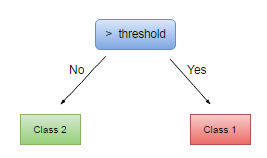

Chaque point d'un ensemble obtient un poid: 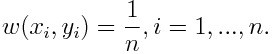

Ensuite, en utilisant une des variables explicatives, il construit un _stump_ et lui attribue un poid en fonction du nombre de point de donnée qu'il n'a pas prédit correctement et du poid de chacun des points de données respectifs:
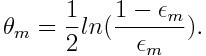

Pour tous les points de données qui n'ont pas été prédit correctement, on modifie leur poid afin qu'à la prochaine itérations ils aient plus d'importance dans la construction des _stumps_.
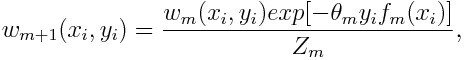

Cela permet de mettre plus de poid sur les points de donnés qui sont plus dur à classifier et moins de poid sur les points plus faciles.
###### (source:https://towardsdatascience.com/boosting-algorithm-adaboost-b6737a9ee60c)

### 4.3.2 Application du modèle

Les variables explicatives choisi sont les mêmes que celle utilisé pour la forêt aléatoire sans Adaboost: mois, pcp_sum et pcp_max. Ce type d'arbre a été abandonné, car après l'avoir testé, nous avons eu un score de 0.70, ce qui est inférieur à ce que la randomforest nous a donnée.

### 4.3.3 Création de la forêt aléatoire Adaboost

Les arguments des fonctions build_adaboost_stumps ont été selectionné de manière arbitraire. 

-7 iterations par _stumps_

In [51]:
#1
predictors1 =[float.(O4350[:SUM]) float.(O4350[:MAX]) float.(month_O4350)]
model_O4350_ada, coeffs_O4350 = build_adaboost_stumps(string.(O4350[:SURVERSE]), predictors1, 10);
#2
predictors2 =[float.(O4240[:SUM]) float.(O4240[:MAX]) float.(month_O4240)]
model_O4240_ada, coeffs_O4240 = build_adaboost_stumps(string.(O4240[:SURVERSE]), predictors2, 10);

#3
predictors3 =[float.(O3350[:SUM]) float.(O3350[:MAX]) float.(month_O3350)]
model_O3350_ada, coeffs_O3350 = build_adaboost_stumps(string.(O3350[:SURVERSE]), predictors3, 10);
#4
predictors4 =[float.(O3260[:SUM]) float.(O3260[:MAX]) float.(month_O3260)]
model_O3260_ada, coeffs_O3260 = build_adaboost_stumps(string.(O3260[:SURVERSE]), predictors4,10);

#5
predictors5 =[float.(O4380[:SUM]) float.(O4380[:MAX]) float.(month_O4380)]
model_O4380_ada, coeffs_O4380 = build_adaboost_stumps(string.(O4380[:SURVERSE]), predictors5,10);

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[51]:1
└ @ Core In[51]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[51]:1
└ @ Core In[51]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[51]:3
└ @ Core In[51]:3


UndefVarError: UndefVarError: build_adaboost_stumps not defined

### 4.3.4 - Analyse des forêts Adaboost crées 

#### Ouvrage 4350-01D

In [52]:
accuracy = nfoldCV_stumps(string.(O4350[:SURVERSE]), predictors_O4350,3,7)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[52]:1
└ @ Core In[52]:1


UndefVarError: UndefVarError: nfoldCV_stumps not defined

#### Ouvrage 3350-07D

In [53]:
accuracy = nfoldCV_stumps(string.(O3350[:SURVERSE]), predictors_O3350, 3,7)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[53]:1
└ @ Core In[53]:1


UndefVarError: UndefVarError: nfoldCV_stumps not defined

#### Ouvrage 4240-01D

In [54]:
accuracy = nfoldCV_stumps(string.(O4240[:SURVERSE]), predictors_O4240, 3,7)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[54]:1
└ @ Core In[54]:1


UndefVarError: UndefVarError: nfoldCV_stumps not defined

#### Ouvrage 3260-01D

In [55]:
accuracy = nfoldCV_stumps(string.(O3260[:SURVERSE]), predictors_O3260, 3,7)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[55]:1
└ @ Core In[55]:1


UndefVarError: UndefVarError: nfoldCV_stumps not defined

#### Ouvrage 4380-01D

In [56]:
accuracy = nfoldCV_stumps(string.(O4380[:SURVERSE]), predictors_O4380, 3,7)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[56]:1
└ @ Core In[56]:1


UndefVarError: UndefVarError: nfoldCV_stumps not defined

### 4.3.5 Création d'une fonction pour faire appel aux modèles de forêt Adaboost

In [57]:
function Adaboostforest(sumpluie::Float64, maxpluie::Float64, ouvrage::String, mois::Float64)
    
    value = 0
    
    if(ouvrage == "4350-01D")
        value = apply_adaboost_stumps(model_O4350_ada, coeffs_O4350, [sumpluie, maxpluie, mois])
        println(apply_adaboost_stumps_proba(model_O4350_ada, coeffs_O4350,[sumpluie, maxpluie, mois], ["1","0"]))
    elseif(ouvrage == "4240-01D")
        value = apply_adaboost_stumps(model_O4240_ada, coeffs_O4240, [sumpluie, maxpluie, mois])
        println(apply_adaboost_stumps_proba(model_O4240_ada, coeffs_O4240, [sumpluie, maxpluie, mois], ["1","0"]))
    elseif(ouvrage == "3350-07D")
        value = apply_adaboost_stumps(model_O3350_ada, coeffs_O3350, [sumpluie, maxpluie, mois])
        println(apply_adaboost_stumps_proba(model_O3350_ada, coeffs_O3350, [sumpluie, maxpluie, mois], ["1","0"]))
    elseif(ouvrage == "3260-01D")
        value = apply_adaboost_stumps(model_O3260_ada, coeffs_O3260, [sumpluie, maxpluie, mois])
        println(apply_adaboost_stumps_proba(model_O3260_ada, coeffs_O3260, [sumpluie, maxpluie, mois], ["1","0"]))
    elseif(ouvrage == "4380-01D")
        value = apply_adaboost_stumps(model_O4380_ada, coeffs_O4380, [sumpluie, maxpluie, mois])
        println(apply_adaboost_stumps_proba(model_O4380_ada, coeffs_O4380, [sumpluie, maxpluie, mois], ["1","0"]))    
    end
    
    return value
end

Adaboostforest (generic function with 1 method)

### 4.3.6 Conclusion

L'algorithme Adaboost nous a permis d'obtenir une note kaggle de 70.7 ce qui n'est pas une amélioration par rapport la méthode de la forêt aléatoire.À cet effet, nous rejettons ce modèle car il n'apporte rien de plus que la forêt aléatoire n'apporte pas. Nous pensons qu'après un certain nombre d'itérations, le modèle ce sûr-entraine et n'est donc pas assez général pour prédire d'autres points de données. Il faudrait alors trouver le nombres d'itérations optimal qui permettrait de ne pas sûr-entrainer ou sous-entrainer le modèle.

<a id="5"></a>
# 5 - Methode Bayesienne Naive

## 5.1 pretraitement pour Bayesienne Naive

### Jointure entre le data et les labels

In [58]:
rename!(surverse_df, :DATE => :date)
data_joined_tot_day = join(pcp_sum, surverse_df, on = :date)
first(data_joined_tot_day, 5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert,NO_OUVRAGE,SURVERSE
,Date,Int64,Int64,Int64,Int64,Int64,String,Int64
1,2013-05-01,0,0,0,0,0,0642-01D,0
2,2013-05-01,0,0,0,0,0,0672-01D,0
3,2013-05-01,0,0,0,0,0,0672-02D,0
4,2013-05-01,0,0,0,0,0,0672-03D,0
5,2013-05-01,0,0,0,0,0,0801-01D,0


In [59]:
data_joined_max_day = join(pcp_max, surverse_df, on = :date)
first(data_joined_max_day, 5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert,NO_OUVRAGE,SURVERSE
,Date,Int64,Int64,Int64,Int64,Int64,String,Int64
1,2013-05-01,0,0,0,0,0,0642-01D,0
2,2013-05-01,0,0,0,0,0,0672-01D,0
3,2013-05-01,0,0,0,0,0,0672-02D,0
4,2013-05-01,0,0,0,0,0,0672-03D,0
5,2013-05-01,0,0,0,0,0,0801-01D,0


on definit ici quelques variables utiles lors des manipulation des données et de la construction du modèle.

In [60]:
ouvrages = ["3260-01D" "3350-07D" "4240-01D" "4350-01D" "4380-01D"]
stations = [:McTavish :Bellevue :Assomption :Trudeau :StHubert]
index_ouvrages = Dict{String,Integer}("3260-01D" => 1, "3350-07D" => 2, "4240-01D"=>3, "4350-01D"=>4, "4380-01D"=>5)
index_stations = Dict{String,Integer}("McTavish" => 1, "Bellevue" => 2, "Assomption"=>3, "Trudeau" => 4, "StHubert"=>5)
F_T = [false true]
n_ouvrages = length(ouvrages)
n_station = length(stations)

5

## 5.2 Definition de l'intervalle de test et d'entrainement

Nous entrainons nos données sur tous l'ensemble des 170 ouvrages alors que le modele n'est entrainé que pour fonctionner sur 5 ouvrages particuliers. Il faudrait donc le prendre en compte, lors de la validation du modèle, et utiliser seulement des données d'une de l'une de des stations faisant partie du modèle. Nous selectionneron donc notre échantillon test parmi les données filtrées suivantes.

In [61]:
x = filter!(row -> row.NO_OUVRAGE ∈ ouvrages, copy(data_joined_max_day));
size(x)

(5129, 8)

Nous testerons no données sur 500 valeurs de tets. Comme on le vois si haut, nous n'avons que 5000 valeurs disponibles

In [62]:
size_test = 500
n = size(x,1)
idxs = randperm(n)
test = idxs[1:size_test]
X_test = convert(Matrix,x[test,[1, 7, 8]])
first(x[test,:],5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert,NO_OUVRAGE,SURVERSE
,Date,Int64,Int64,Int64,Int64,Int64,String,Int64
1,2016-09-13,0,0,0,0,0,4350-01D,0
2,2014-10-11,0,0,0,0,0,4240-01D,0
3,2018-06-25,0,0,2,0,0,4380-01D,0
4,2016-08-01,0,0,0,0,0,4350-01D,0
5,2017-05-09,2,2,0,0,0,3260-01D,0


Ces données devrait etres exclue du dataset d'entrainement. Elle ne l'ont pas été car Julia n'offre pas d'imprementation de la fonction subtract (qui existe sur pandas). On considère que les valeurs qui son laissées dans le dataframe on un impact minimes sur le modèle, vu leur petit nombre. Mais il faut prendre les resulat du test de validation avec beacoup de distance.

## 5.3 Application de la methode

À l'aide du théorème de bayes, on considère les variables explicatives comme conditionnellement indépendante pour les cas où il y a une surverse et ceux où il n'y en a pas. On considère ensuite les variables explicatives continues, comme suivant une normale, il reste possible d’utiliser d’autres distribution pour représenter les données de précipitations. On construit ensuite les normales conditionnelles pour chaque station pluviométrique. Comme il existe une dépendance entre les quantités de pluies des stations en une journée (vérifiable a en faisant une divergence de kullback-leiblar), on essaiera un modèle avec une normale par station et un à l’autre avec des normales multivariées. Même si avec le deuxième modèle s’écarte de la méthode bayésienne naïve.

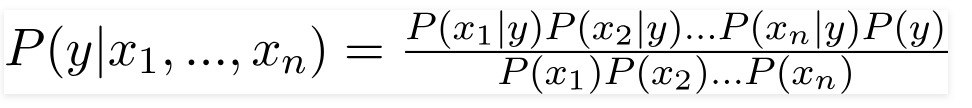

Pour le classificateur binaire, il suffit de multiplier les probabiliter conditionnelle comme au numerateur. Ensuite on peut ignorer le denominateur car il s'agit d'une constante entre les deux probabilités et peut donc etre ignoré. Nous avons pris la decision d'utiliser une loi a priori de 1 pour les deux cas (y = 1 et y = 0). En prenant en compte c'est ensemble de suppositions, on peut conclure que la probabilité conditionnelles pour les surverses s'ecrira :

Où les deux premieres variables aleatoires sont les precipitations et la troisieme represente l'ouvrage de la surverse. Il faut noter que chaque variable explication est constituer de mesures sur différentes station nous considereron une seul densité et deux methodes seront explorée pour estimer cette densité, la premiere étant un ensemble de normales, on considère alors les différentes mesures comme independantes (bayesian naive) et on multiplie les densité de chaque normale. Avce la deuxieme methode on ne fait pas cette hypothèse et on utilise une seule normale.

### 5.3.1 - Variable 1 : Precipitation totales par jours

#### Estimation de la densité:

Nous utiliseron les estimateurs de moyenne et de de variance du maximum de vraisemblance pour trouver les parametres de la normale. La premiere colone represente les normales des maximums par jours où il y a eu de surverse. Alors que pour la deuxieme colone il y en a eu. Chaque ligne du tableau indique une station en particulier.

In [63]:
distributions_sum_jour = Array{Normal{Float64}}(undef,n_station,2)
for k in 1:2
    # on filtre sur les surverse, une fois 1 et une fois 0
    y_surverse = filter(row -> row.SURVERSE == F_T[k], copy(data_joined_tot_day))
    for j in 1:n_station
        # on prend les données pour chaques station
        y_ouvrage_station = y_surverse[:, stations[j]]
        distributions_sum_jour[j,k] = Normal(mean(y_ouvrage_station), sqrt(var(y_ouvrage_station)))
    end
end
distributions_sum_jour

5×2 Array{Normal{Float64},2}:
 Normal{Float64}(μ=26.71, σ=67.5456)    Normal{Float64}(μ=187.345, σ=155.008)
 Normal{Float64}(μ=23.006, σ=58.9001)   Normal{Float64}(μ=150.476, σ=136.476)
 Normal{Float64}(μ=29.2324, σ=73.6692)  Normal{Float64}(μ=184.336, σ=160.073)
 Normal{Float64}(μ=23.5763, σ=60.0564)  Normal{Float64}(μ=161.981, σ=137.414)
 Normal{Float64}(μ=23.9182, σ=57.8918)  Normal{Float64}(μ=157.592, σ=122.014)

Une seule normale multivariée est utilisée pourtoutes les stations. On prend ainsi en compte la dependence de la quantité de precipitation mesurée edes différentes stations pour la même variable explicative (ici la somme sur une journée). On considere dependant toujours une independance contitionnelle des différentes variables explicatives.

In [65]:
distributions_sum_jour_multivariate = Array{Any}(undef,2)
for i in 1:2
    # on filtre sur les surverse, une fois 1 et une fois 0
    y_surverse = filter(row -> row.SURVERSE == F_T[i], copy(data_joined_max_day))[:,2:6]
    #on trouve la matrice de covariance et le vecteur de moyenne
    y_surverse = convert(Matrix,y_surverse)
    moyenne , covar = mean_and_cov(y_surverse,corrected=true)
    distributions_sum_jour_multivariate[i] = MvNormal(vec(moyenne) , sqrt.(covar))
end

### 5.3.2 - Variable 2 : precipitaion maximale par jour

Cette variable explicative est traitée exactement de la même manière que la première.

In [66]:
distributions_max_jour = Array{Normal{Float64}}(undef,n_station,2)
for k in 1:2
    # on filtre sur les surverse, une fois 1 et une fois 0
    y_surverse = filter(row -> row.SURVERSE == F_T[k], copy(data_joined_max_day))
    for j in 1:n_station
        # on prend les données pour chaques station
        y_ouvrage_station = y_surverse[:, stations[j]]
        distributions_max_jour[j,k] = Normal(mean(y_ouvrage_station), sqrt(var(y_ouvrage_station)))
    end
end
distributions_max_jour

5×2 Array{Normal{Float64},2}:
 Normal{Float64}(μ=11.5881, σ=28.0391)  Normal{Float64}(μ=71.373, σ=59.5805) 
 Normal{Float64}(μ=10.4134, σ=26.2891)  Normal{Float64}(μ=59.7042, σ=56.072) 
 Normal{Float64}(μ=13.8848, σ=33.9487)  Normal{Float64}(μ=72.1508, σ=67.3384)
 Normal{Float64}(μ=10.8972, σ=27.4604)  Normal{Float64}(μ=64.8011, σ=56.4929)
 Normal{Float64}(μ=10.6403, σ=25.3677)  Normal{Float64}(μ=60.3007, σ=47.8691)

In [67]:
distributions_max_jour_multivariate = Array{Any}(undef,2)
for i in 1:2
    # on filtre sur les surverse, une fois 1 et une fois 0
    y_surverse = filter(row -> row.SURVERSE == F_T[i], copy(data_joined_max_day))[:,2:6]
    #on trouve la matrice de covariance et le vecteur de moyenne
    y_surverse = convert(Matrix,y_surverse)
    moyenne , covar = mean_and_cov(y_surverse, corrected=true)
    distributions_max_jour_multivariate[i] = MvNormal(vec(moyenne) , sqrt.(covar))
end

### 5.3.3 - Variable 3 : ouvrage

Cette variable explicative est discrete. On peut donc estimer la probabilité pour chaqun des cas avec l'estimateur echantillonal pour chaque surverse.

In [68]:
prob_ouvrage = Array{Float64}(undef,n_ouvrages,2)
    
for j in 1:n_ouvrages
    # on filtre sur les surverse, une fois 1 et une fois 0
    y_ouvrage = select(filter(row -> row.NO_OUVRAGE == ouvrages[j], copy(data_joined_max_day)), [:SURVERSE])
    prob = sum(y_ouvrage[:,:SURVERSE]) / size(y_ouvrage[:,:SURVERSE])[1]
    prob_ouvrage[j,:] = [prob 1-prob]
end

## 5.4 -La fonction categorisation utilise le modele entrainé pour effectuer une prediction. 

In [69]:
## in : DATE (permet d'obtenir les precipitation)
## in : is multivariate
## out : 0 => non, 1 => oui
## utilise : propa de chaque V.A utilisées
function categorisation(no_ouvrgages::String, dt::Date, isMultivariate::Bool)
    ## 2. Trouver les données de précipitation pour la date à predire.
    precp_sum = select!(filter(row -> row.date == dt, pcp_sum), [:McTavish, :Bellevue, :Assomption, :Trudeau, :StHubert])
    precp_max = select!(filter(row -> row.date == dt, pcp_max), [:McTavish, :Bellevue, :Assomption, :Trudeau, :StHubert])
    
    ## 3. Trouver mois, numero ouvrage, numero station
    index_ouvrage = index_ouvrages[no_ouvrgages]
    
    ## 4. Evaluer densités normales et probas 
    p₁₁ = 1 
    p₁₂ = 1
    p₁₃ = prob_ouvrage[index_ouvrage,2]
    
    p₀₁ = 1
    p₀₂ = 1
    p₀₃ = prob_ouvrage[index_ouvrage,1]
    
    if isMultivariate
        p₁₁ = pdf(distributions_sum_jour_multivariate[2],vec(convert(Matrix, precp_sum[:,1:5])))
        p₀₁ = pdf(distributions_sum_jour_multivariate[1],vec(convert(Matrix, precp_sum[:,1:5])))
    
        p₁₂ = pdf(distributions_max_jour_multivariate[2],vec(convert(Matrix, precp_max[:,1:5])))
        p₀₂ = pdf(distributions_max_jour_multivariate[1],vec(convert(Matrix, precp_max[:,1:5])))
    else
        for i in 1:n_station
            p₁₁ *= pdf.(distributions_sum_jour[i,2],precp_sum[1,i])[1]
            p₀₁ *= pdf.(distributions_sum_jour[i,1],precp_sum[1,i])[1]

            p₁₂ *= pdf.(distributions_max_jour[i,2],precp_max[1,i])[1]
            p₀₂ *= pdf.(distributions_max_jour[i,1],precp_max[1,i])[1]
        end
     end
    
    ## 5. Multiplier les proba et faire bayes
    p₁ = p₁₁ * p₁₂ * p₁₃
    p₀ = p₀₁ * p₀₂ * p₀₃
    
    return p₁ > p₀ ? 1 : 0
end

categorisation (generic function with 1 method)

### 5.4.1 - Choisisson le modèle qui donne les meilleurs resulats

In [75]:
ŷ = categorisation.(X_test[:,2],X_test[:,1],false)
sum( ŷ .==  X_test[:,3]) / length(ŷ)

0.918

In [76]:
ŷ = categorisation.(X_test[:,2],X_test[:,1],true)
sum( ŷ .==  X_test[:,3]) / length(ŷ)

0.79

On choisis donc d'effectuer nos prediction on utilisation une implementation rigoureuse de la methode Bayesienne naive. Noter que les deux methodes ont été soumise - pour ne pas se fier uniquement sur le test et que la deuxieme a effectivement donner une meilleure solution. 

### 5.5 - Synthese bayesienne Naive 

À l'aide de cette methode prise individuellement, un resultat maximum d'environ 0.74 (avant traitement des valeurs maquantes) a été ateinds. Une methode à été experimentée où uniquement les 5 ouvrages etaient utilisés. Il y avait alors une normale par ouvrage et les ouvrages. Ceux-ci n'etaient donc pas considérés comme une variable explicative mais comme une données. Et pour effectuer une prediction, seule la normale de l'ouvrage correspondant etait utilisées. Ce modèle était un peu moins performant que le modèle actuel (0.73) et il etait plus complexe, car il necessite 50 normales au lieu de 10. le factueur de 5 proviens du fait qu'on a la meme normale pour tous les ouvrage.

# 6 -  Combinaison de modèle

Suite à une validation croisée de chacun de nos modèles, nous avons remarqué que certains d’entre eux présentaient très peu de faux-positif. C’est-à-dire que lorsque le modèle prévoit une surverse, il y a de forte chance qu’il ait raison - Ceci decoule du fait qu'il est difficile pour le modele de predire des 1 du au grand nombre de 0, ceux-ci sont toujour favorisé-. À cet effet, nous avons décidé de faire appel au blending (mélange de modèle). Les modèles mélanger sont la forêt aléatoire et la méthode Bayésien Naïve, qui on un fonctionnement assez different et comportent très peu de faux-positif. Par conséquent, lorsque mélangé à l’aide d’un OU, nous obtenons de bon résultats car a partir du moment ou un des deux modeles predit une surverse, il y a de forte chance qu’il ai raison.

# Création du fichier de prédictions pour soumettre sur Kaggle

Dans ce cas-ci, nous prédirons une surverse avec une probabilité de 1/2 sans considérer aucune variable explicative.

In [77]:
test = CSV.read("data/test.csv");

In [78]:
prediction_NAIV_BAYES = []

n = size(test,1)
for i in eachrow(test)
     push!(prediction_NAIV_BAYES, categorisation(i[:NO_OUVRAGE], i[:DATE],false))
end

In [79]:
surverse = []
for i in eachrow(test)
    
    
    indsum = findfirst(pcp_sum[:,:date] .== i[:DATE])
    indmax = findfirst(pcp_max[:,:date] .== i[:DATE])
    sum = 0.0
    max = 0.0
    
    if (i[:NO_OUVRAGE] == "4350-01D" || i[:NO_OUVRAGE] =="4380-01D")
        sum = pcp_sum[indsum,:McTavish]
        max = pcp_max[indmax,:McTavish]
    elseif (i[:NO_OUVRAGE] == "4240-01D" || i[:NO_OUVRAGE] == "3260-01D")
        sum = floor((pcp_sum[indsum,:McTavish] + pcp_sum[indsum,:Assomption] + pcp_sum[indsum,:StHubert])/3)
        max = maximum([pcp_max[indmax,:McTavish], pcp_max[indmax,:Assomption], pcp_max[indmax,:StHubert]])
    elseif (i[:NO_OUVRAGE] == "3350-07D")
        sum = floor((pcp_sum[indsum,:McTavish] + pcp_sum[indsum,:Trudeau])/2)
        max = maximum([pcp_max[indmax,:McTavish], pcp_max[indmax,:Trudeau]])
    end 
    
    if(ismissing(sum))
        sum = mean(skipmissing(pcp_sum[!,:McTavish]))
    end
    
    if(ismissing(max))
        max = mean(skipmissing(pcp_max[!,:McTavish]))
    end

    push!(surverse,randomforest( float.(sum), float.(max), i[:NO_OUVRAGE], float.(month(i[:DATE]))))
end

UndefVarError: UndefVarError: apply_forest not defined

In [80]:
# Création du fichier Submission.csv pour soumettre sur Kaggle
soumission = surverse .| prediction_NAIV_BAYES
ID = test[:,:NO_OUVRAGE].*"_".*string.(test[:,:DATE])
sampleSubmission = DataFrame(ID = ID, Surverse=surverse)
CSV.write("Submission.csv",sampleSubmission)

# Vous pouvez par la suite déposer le fichier sampleSubmission.csv sur Kaggle.
first(test,5);

UndefVarError: UndefVarError: surverse not defined

### Conclusion

Plusieurs améliorations auraient pu être apportées à notre démarche. Notamment, il aurait été utile d'approfondir l'analyse exploratoire des données afin de tenter d"identifier davantage de variables explicatives potentielles, surtout en ce qui a trait à la localisation des différents ouvrages et des stations. Aussi, il aurait été pertinent d'évaluer la performance du modèle de prévision adopté en utilisant plus qu'un critère afin de renforcer notre confiance par rapport à son pouvoir prédictif.
